In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random as rd
import importlib 
import Rebound_WTA_lib as WTA
importlib.reload(WTA)

<module 'Rebound_WTA_lib' from '/home/cfs/yh415/code_py/HCO_Hoppfield/Rebound_WTA_lib.py'>


# Rebound excitability and Bursting of Excitable Neurons

/tmp/ipykernel_979144/21669621.py:17: RuntimeWarning: overflow encountered in exp
  return 0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10))
/tmp/ipykernel_979144/21669621.py:20: RuntimeWarning: overflow encountered in exp
  return 4.0 * np.exp(-(V + 65) / 18)
/tmp/ipykernel_979144/21669621.py:23: RuntimeWarning: overflow encountered in exp
  return 0.07 * np.exp(-(V + 65) / 20)
/tmp/ipykernel_979144/21669621.py:26: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1 + np.exp(-(V + 35) / 10))
/tmp/ipykernel_979144/21669621.py:31: RuntimeWarning: overflow encountered in exp
  return 0.01 * (V + 55) / (1 - np.exp(-(V + 55) / 10))
/tmp/ipykernel_979144/21669621.py:34: RuntimeWarning: overflow encountered in exp
  return 0.125 * np.exp(-(V + 65) / 80)


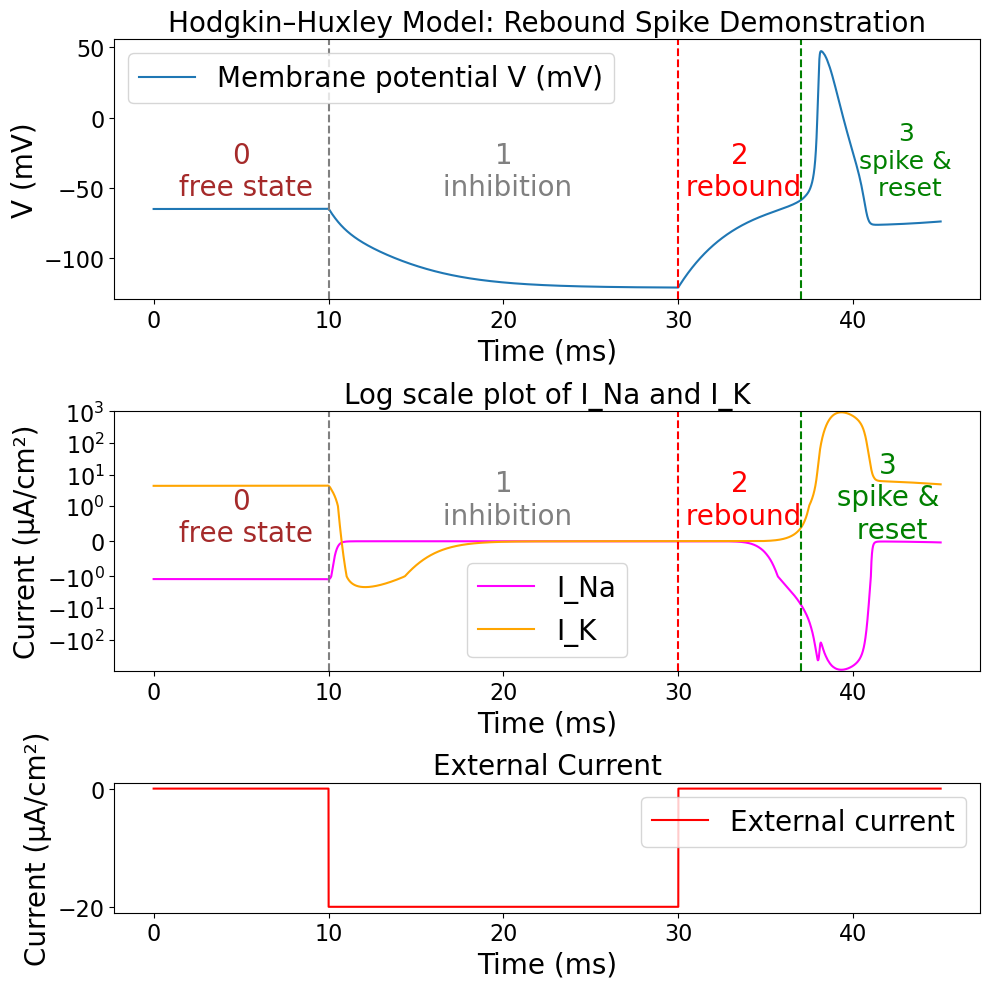

In [3]:
from scipy.integrate import solve_ivp

# Hodgkin-Huxley parameters
C   = 1.0        # membrane capacitance, uF/cm^2
gNa = 120.0      # maximum sodium conductance, mS/cm^2
gK  = 36.0       # maximum potassium conductance, mS/cm^2
gL  = 0.3        # leak conductance, mS/cm^2
ENa = 50.0       # sodium reversal potential, mV
EK  = -77.0      # potassium reversal potential, mV
EL  = -54.387    # leak reversal potential, mV

# Rate functions (voltage in mV)
def alpha_m(V):
    # Avoid division by zero using a limit when V ~ -40 mV
    if abs(V + 40) < 1e-6:
        return 1.0
    return 0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10))

def beta_m(V):
    return 4.0 * np.exp(-(V + 65) / 18)

def alpha_h(V):
    return 0.07 * np.exp(-(V + 65) / 20)

def beta_h(V):
    return 1.0 / (1 + np.exp(-(V + 35) / 10))

def alpha_n(V):
    if abs(V + 55) < 1e-6:
        return 0.1
    return 0.01 * (V + 55) / (1 - np.exp(-(V + 55) / 10))

def beta_n(V):
    return 0.125 * np.exp(-(V + 65) / 80)

# Define the HH differential equations
def diff(t, x, u_func):
    V, m, h, n = x
    u = u_func(t)  # external current at time t
    INa = gNa * m**3 * h * (V - ENa)
    IK  = gK  * n**4      * (V - EK)
    IL  = gL * (V - EL)
    dVdt = (u - INa - IK - IL) / C
    dmdt = alpha_m(V)*(1 - m) - beta_m(V)*m
    dhdt = alpha_h(V)*(1 - h) - beta_h(V)*h
    dndt = alpha_n(V)*(1 - n) - beta_n(V)*n
    return [dVdt, dmdt, dhdt, dndt]

# External current: a hyperpolarizing pulse (inhibition) that is switched off.
# For example, apply a negative current for t < 100 ms, then u = 0.
def u_func(t):
    if t < 10:
        return 0.0  # hyperpolarizing current (in µA/cm^2)
    else:
        if t<30:
            return -20.0
        else:
            return 0.0

# Simulation parameters
t_start = 0
t_end   = 45   # simulation time in ms
t_eval  = np.linspace(t_start, t_end, 30001)

# Initial conditions (resting state at V = -65 mV)
V0 = -65.0
m0 = alpha_m(V0) / (alpha_m(V0) + beta_m(V0))
h0 = alpha_h(V0) / (alpha_h(V0) + beta_h(V0))
n0 = alpha_n(V0) / (alpha_n(V0) + beta_n(V0))
x0 = [V0, m0, h0, n0]

# Solve the HH ODEs using solve_ivp
sol = solve_ivp(lambda t, x: diff(t, x, u_func),
                (t_start, t_end), x0, t_eval=t_eval)

# Compute currents using simulation results:
V = sol.y[0]
m = sol.y[1]
h = sol.y[2]
n = sol.y[3]

INa = gNa * m**3 * h * (V - ENa)
IK  = gK  * n**4 * (V - EK)

# Plot the membrane potential to demonstrate rebound spiking
# Set font sizes
caption_size = 20
title_size = 20
axis_size = 16

# Create a figure with three subplots:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,10), 
                                        gridspec_kw={'height_ratios': [2, 2, 1]})


# Top subplot - Membrane potential
ax1.plot(sol.t, sol.y[0], label="Membrane potential V (mV)")
ax1.axvline(x=10, color='gray', linestyle='--')
ax1.axvline(x=30, color='red', linestyle='--')
ax1.axvline(x=37, color='green', linestyle='--')
# ax1.axvline(x=41, color='brown', linestyle='--')
ax1.set_xlabel("Time (ms)", fontsize=caption_size)
ax1.set_ylabel("V (mV)", fontsize=caption_size)
ax1.set_title("Hodgkin–Huxley Model: Rebound Spike Demonstration", fontsize=title_size)
ax1.legend(fontsize=caption_size)
ax1.tick_params(axis='both', which='major', labelsize=axis_size)

y_min, y_max = ax1.get_ylim()
y_text_1 = y_min + 0.4 * (y_max - y_min)
y_text_2 = y_min + 0.4 * (y_max - y_min)
y_text_3 = y_min + 0.4 * (y_max - y_min)


# Add stage numbers on the top subplot near the vertical lines:

ax1.text(5, y_text_1, "0\n free state", fontsize=caption_size, color='brown', ha='center')

# Stage 1: Start of inhibition at x=10
ax1.text(20, y_text_1, "1\n inhibition", fontsize=caption_size, color='gray', ha='center')

# Stage 2: End of inhibition / start of rebound at x=50
ax1.text(33.5, y_text_2, "2\n rebound", fontsize=caption_size, color='red', ha='center')

# Stage 3: End of rebound / start of spike at x=57
ax1.text(43, y_text_3, "3\n spike & \n reset", fontsize=caption_size*0.9, color='green', ha='center')


# Bottom subplot - Current stimulus
u_values = np.array([u_func(t) for t in sol.t])
ax3.plot(sol.t, u_values, color='red', label="External current")
ax3.set_xlabel("Time (ms)", fontsize=caption_size)
ax3.set_ylabel("Current (µA/cm²)", fontsize=caption_size)
ax3.set_title("External Current", fontsize=title_size)
ax3.legend(fontsize=caption_size)
ax3.tick_params(axis='both', which='major', labelsize=axis_size)

# Bottom subplot: INa and IK currents
y_min, y_max = ax2.get_ylim()
y_text_0 = y_min + 0.0 * (y_max - y_min)
y_text_1 = y_min + 0.5 * (y_max - y_min)
y_text_2 = y_min + 0.5 * (y_max - y_min)
y_text_3 = y_min + 0.1 * (y_max - y_min)

ax2.plot(sol.t, INa, label="I_Na", color='magenta')
ax2.plot(sol.t, IK,  label="I_K",  color='orange')
ax2.axvline(x=10, color='gray', linestyle='--')
ax2.axvline(x=30, color='red', linestyle='--')
ax2.axvline(x=37, color='green', linestyle='--')
# ax2.axvline(x=41, color='brown', linestyle='--')
ax2.set_yscale('symlog', linthresh=1)
ax2.set_xlabel("Time (ms)", fontsize=caption_size)
ax2.set_ylabel("Current (µA/cm²)", fontsize=caption_size)
ax2.set_title("Log scale plot of I_Na and I_K", fontsize=title_size)
ax2.legend(fontsize=caption_size)
ax2.tick_params(axis='both', which='major', labelsize=axis_size)

ax2.text(5, y_text_0, "0\n free state", fontsize=caption_size, color='brown', ha='center')

ax2.text(20, y_text_1, "1\n inhibition", fontsize=caption_size, color='gray', ha='center')

# Stage 2: End of inhibition / start of rebound at x=50
ax2.text(33.5, y_text_2, "2\n rebound", fontsize=caption_size, color='red', ha='center')

# Stage 3: End of rebound / start of spike at x=57
ax2.text(42, y_text_3, "3\n spike & \n reset", fontsize=caption_size, color='green', ha='center')

plt.tight_layout()
plt.savefig('rebound_spike.png',dpi=300)
plt.show()





/tmp/ipykernel_925012/1871822263.py:18: RuntimeWarning: overflow encountered in exp
  return 0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10))
/tmp/ipykernel_925012/1871822263.py:21: RuntimeWarning: overflow encountered in exp
  return 4.0 * np.exp(-(V + 65) / 18)
/tmp/ipykernel_925012/1871822263.py:24: RuntimeWarning: overflow encountered in exp
  return 0.07 * np.exp(-(V + 65) / 20)
/tmp/ipykernel_925012/1871822263.py:27: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1 + np.exp(-(V + 35) / 10))
/tmp/ipykernel_925012/1871822263.py:32: RuntimeWarning: overflow encountered in exp
  return 0.01 * (V + 55) / (1 - np.exp(-(V + 55) / 10))
/tmp/ipykernel_925012/1871822263.py:35: RuntimeWarning: overflow encountered in exp
  return 0.125 * np.exp(-(V + 65) / 80)


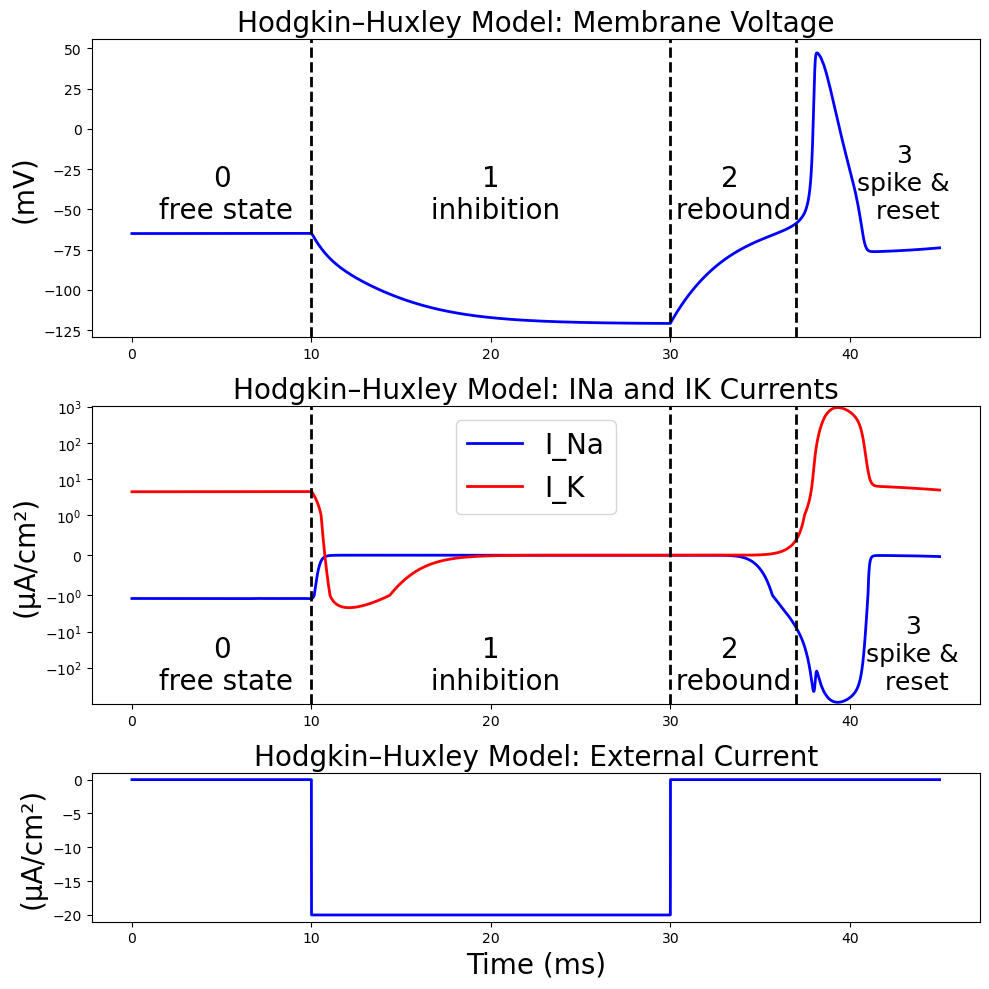

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Hodgkin-Huxley parameters
C   = 1.0        # membrane capacitance, uF/cm^2
gNa = 120.0      # maximum sodium conductance, mS/cm^2
gK  = 36.0       # maximum potassium conductance, mS/cm^2
gL  = 0.3        # leak conductance, mS/cm^2
ENa = 50.0       # sodium reversal potential, mV
EK  = -77.0      # potassium reversal potential, mV
EL  = -54.387    # leak reversal potential, mV

# Rate functions (voltage in mV)
def alpha_m(V):
    if abs(V + 40) < 1e-6:
        return 1.0
    return 0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10))

def beta_m(V):
    return 4.0 * np.exp(-(V + 65) / 18)

def alpha_h(V):
    return 0.07 * np.exp(-(V + 65) / 20)

def beta_h(V):
    return 1.0 / (1 + np.exp(-(V + 35) / 10))

def alpha_n(V):
    if abs(V + 55) < 1e-6:
        return 0.1
    return 0.01 * (V + 55) / (1 - np.exp(-(V + 55) / 10))

def beta_n(V):
    return 0.125 * np.exp(-(V + 65) / 80)

# Define the HH differential equations
def diff(t, x, u_func):
    V, m, h, n = x
    u = u_func(t)  # external current at time t
    INa = gNa * m**3 * h * (V - ENa)
    IK  = gK  * n**4      * (V - EK)
    IL  = gL * (V - EL)
    dVdt = (u - INa - IK - IL) / C
    dmdt = alpha_m(V)*(1 - m) - beta_m(V)*m
    dhdt = alpha_h(V)*(1 - h) - beta_h(V)*h
    dndt = alpha_n(V)*(1 - n) - beta_n(V)*n
    return [dVdt, dmdt, dhdt, dndt]

# External current: hyperpolarizing pulse (inhibition)
def u_func(t):
    if t < 10:
        return 0.0
    elif t < 30:
        return -20.0
    else:
        return 0.0

# Simulation parameters
t_start = 0
t_end   = 45   # simulation time in ms
t_eval  = np.linspace(t_start, t_end, 30001)

# Initial conditions (resting state at V = -65 mV)
V0 = -65.0
m0 = alpha_m(V0) / (alpha_m(V0) + beta_m(V0))
h0 = alpha_h(V0) / (alpha_h(V0) + beta_h(V0))
n0 = alpha_n(V0) / (alpha_n(V0) + beta_n(V0))
x0 = [V0, m0, h0, n0]

# Solve the HH ODEs using solve_ivp
sol = solve_ivp(lambda t, x: diff(t, x, u_func),
                (t_start, t_end), x0, t_eval=t_eval)

# Compute simulation results
V = sol.y[0]
m = sol.y[1]
h = sol.y[2]
n = sol.y[3]

INa = gNa * m**3 * h * (V - ENa)
IK  = gK  * n**4 * (V - EK)

# Set font sizes
caption_size = 20
title_size   = 20
axis_size    = 16

# Create a figure with three subplots:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,10), 
                                      gridspec_kw={'height_ratios': [2, 2, 1]})

# Top subplot - Membrane potential (voltage)
ax1.plot(sol.t, V, linewidth=2, color='blue')
# Dashed vertical lines in black
ax1.axvline(x=10, color='black', linestyle='--', linewidth=2)
ax1.axvline(x=30, color='black', linestyle='--', linewidth=2)
ax1.axvline(x=37, color='black', linestyle='--', linewidth=2)
# Remove x-axis label (time removed)
ax1.set_xlabel("")
# y-axis only for units
ax1.set_ylabel("(mV)", fontsize=caption_size)
ax1.set_title("Hodgkin–Huxley Model: Membrane Voltage", fontsize=title_size)

# Stage labels (using black text)
y_min, y_max = ax1.get_ylim()
y_text = y_min + 0.4*(y_max - y_min)
ax1.text(5, y_text, "0\n free state", fontsize=caption_size, color='black', ha='center')
ax1.text(20, y_text, "1\n inhibition", fontsize=caption_size, color='black', ha='center')
ax1.text(33.3, y_text, "2\n rebound", fontsize=caption_size, color='black', ha='center')
ax1.text(43, y_text, "3\n spike & \n reset", fontsize=caption_size*0.9, color='black', ha='center')

# Middle subplot - INa and IK currents
ax2.plot(sol.t, INa, linewidth=2, color='blue', label="I_Na")
ax2.plot(sol.t, IK,  linewidth=2, color='red',  label="I_K")
ax2.axvline(x=10, color='black', linestyle='--', linewidth=2)
ax2.axvline(x=30, color='black', linestyle='--', linewidth=2)
ax2.axvline(x=37, color='black', linestyle='--', linewidth=2)
# Remove x-axis label for this subplot
ax2.set_xlabel("")
ax2.set_ylabel("(µA/cm²)", fontsize=caption_size)
ax2.set_yscale('symlog', linthresh=1)
ax2.set_title("Hodgkin–Huxley Model: INa and IK Currents", fontsize=title_size)
# Keep the legend here because of the two signals
ax2.legend(fontsize=caption_size)
# Stage labels in black
y_min2, y_max2 = ax2.get_ylim()
y_text_0 = y_min2 + 0.3*(y_max2 - y_min2)
y_text_1 = y_min2 + 0.3*(y_max2 - y_min2)
y_text_2 = y_min2 + 0.3*(y_max2 - y_min2)
y_text_3 = y_min2 + 0.3*(y_max2 - y_min2)
ax2.text(5, y_text_0, "0\n free state", fontsize=caption_size, color='black', ha='center')
ax2.text(20, y_text_1, "1\n inhibition", fontsize=caption_size, color='black', ha='center')
ax2.text(33.3, y_text_2, "2\n rebound", fontsize=caption_size, color='black', ha='center')
ax2.text(43.5, y_text_3, "3\n spike & \n reset", fontsize=caption_size*0.9, color='black', ha='center')

# Bottom subplot - External current
u_values = np.array([u_func(t) for t in sol.t])
ax3.plot(sol.t, u_values, linewidth=2, color='blue')
# Keep the time label on the x-axis for this subplot
ax3.set_xlabel("Time (ms)", fontsize=caption_size)
ax3.set_ylabel("(µA/cm²)", fontsize=caption_size)
ax3.set_title("Hodgkin–Huxley Model: External Current", fontsize=title_size)
# Remove the legend as there's only one signal here

plt.tight_layout()
plt.savefig('rebound_spike.png', dpi=300)
plt.show()


# HCO

## HH

In [2]:
Time=220
Num_sample=22000
dt=Time/Num_sample
Time_line=np.arange(0,Time,dt)

num_neuron=2

x0=np.random.rand(num_neuron,6)*0
x0[0,0]=-75
x0[1,0]=0
x=np.copy(x0)
outputs=[x0]

x02=np.random.rand(2,6)
x2=np.copy(x02)
outputs2=[x2]

inhibit_w=10

syn_current=[0]

for i in range(Num_sample):

    u=np.zeros(num_neuron)

    dx=WTA.ring_ss_hh_center(num_neuron,x,np.random.rand(num_neuron)*0.0+u,syn_strength=0.0,noise=0,inhibit_weight=inhibit_w,current=-1.0)

    x=x+dx*dt

    syn_current.append(WTA.Syn_hh(x[0,4],-1,-65)*inhibit_w)

    outputs.append(x)

outputs_HCO=np.array(outputs)
syn_current_HCO=np.array(syn_current)

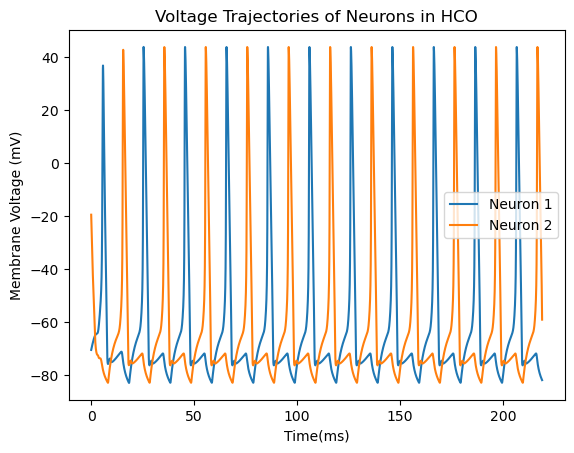

In [123]:
plot_start=100
time_axis=np.arange(0,len(outputs_HCO)-plot_start-1,1)*dt
plt.plot(time_axis,np.array(outputs_HCO)[plot_start+1:,:,0],)
plt.xlabel('Time(ms)')
plt.ylabel('Membrane Voltage (mV)')
plt.title('Voltage Trajectories of Neurons in HCO')
plt.legend([f'Neuron {i+1}' for i in range(2)], loc='best')


# plt.savefig('HH_HCO_plot.png')

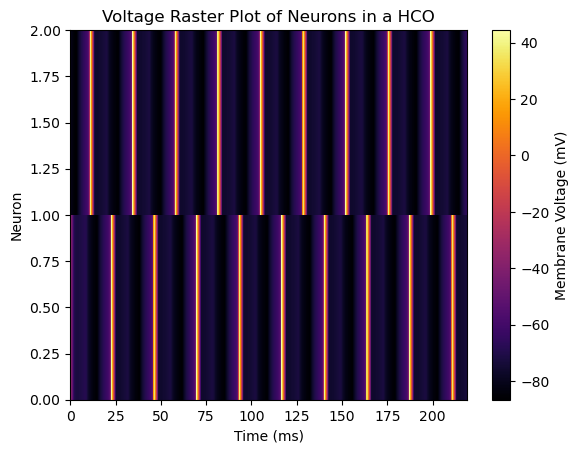

In [5]:
data = np.array(outputs_HCO)[plot_start:,:,0]
# Use imshow to create a raster plot, transposing so neurons appear on the y-axis.
plt.imshow(data.T, aspect='auto', interpolation='nearest', cmap='inferno',extent=[0, data.shape[0] * dt, 0, data.shape[1]])
plt.xlabel('Time (ms)')
plt.ylabel('Neuron')
plt.title('Voltage Raster Plot of Neurons in a HCO')
plt.colorbar(label='Membrane Voltage (mV)')

plt.savefig('HH_HCO_raster.png')





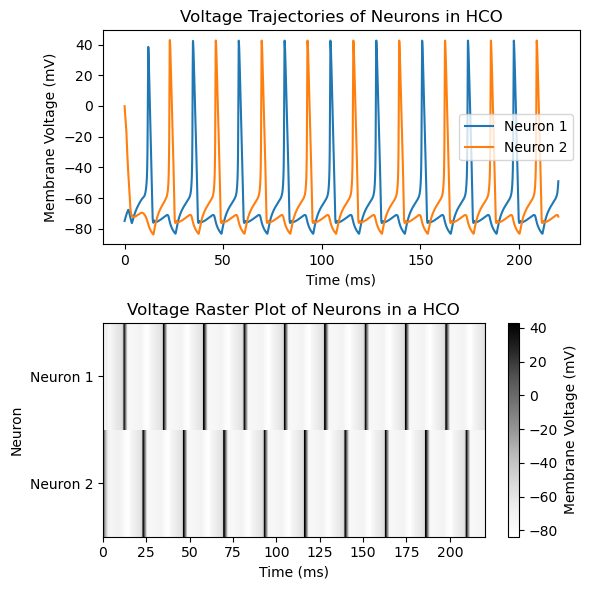

In [4]:
plot_start = 0

# Create a figure with 1 row and 2 columns of subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6))

# --- Left plot: Voltage trajectories line plot ---
time_axis = np.arange(0, len(outputs_HCO) - plot_start - 1, 1) * dt
ax1.plot(time_axis, np.array(outputs_HCO)[plot_start+1:,:,0])
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Membrane Voltage (mV)')
ax1.set_title('Voltage Trajectories of Neurons in HCO')
ax1.legend([f'Neuron {i+1}' for i in range(2)], loc='best')

# --- Right plot: Voltage raster plot ---
data = np.array(outputs_HCO)[plot_start:,:,0]
im = ax2.imshow(data.T, aspect='auto', interpolation='nearest',
                cmap='Greys', extent=[0, data.shape[0] * dt, 0, data.shape[1]])

# Define neuron names, for example:
neuron_names = ['Neuron 2','Neuron 1']

# Set tick positions at the center of each row (pixel)
ax2.set_yticks(np.arange(0.5, data.shape[1], 1))
ax2.set_yticklabels(neuron_names)

ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Neuron')
ax2.set_title('Voltage Raster Plot of Neurons in a HCO')
fig.colorbar(im, ax=ax2, label='Membrane Voltage (mV)')


# Adjust layout so the subplots fit nicely
plt.tight_layout()

# Save the combined figure
plt.savefig('HCO_side_by_side_plot.png')
plt.show()


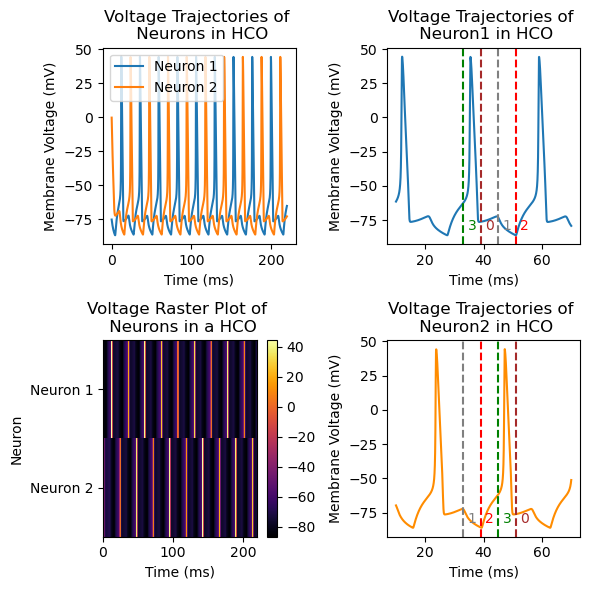

In [78]:
plot_start = 0

# Create a figure with 2 row and 2 columns of subplots
fig, axs = plt.subplots(2, 2, figsize=(6, 6))
ax1, ax2, ax3, ax4 = axs.flatten()  # Flatten the 2x2 array to a 1D array of four axes


# --- Left plot: Voltage trajectories line plot ---
time_axis = np.arange(0, len(outputs_HCO) - plot_start - 1, 1) * dt
ax1.plot(time_axis, np.array(outputs_HCO)[plot_start+1:,:,0])
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Membrane Voltage (mV)')
ax1.set_title('Voltage Trajectories of \n Neurons in HCO')
ax1.legend([f'Neuron {i+1}' for i in range(2)], loc='best')

# --- Right plot: Voltage raster plot ---
data = np.array(outputs_HCO)[plot_start:,:,0]
im = ax3.imshow(data.T, aspect='auto', interpolation='nearest',
                cmap='inferno', extent=[0, data.shape[0] * dt, 0, data.shape[1]])

# Define neuron names, for example:
neuron_names = ['Neuron 2','Neuron 1']

# Set tick positions at the center of each row (pixel)
ax3.set_yticks(np.arange(0.5, data.shape[1], 1))
ax3.set_yticklabels(neuron_names)

ax3.set_xlabel('Time (ms)')
ax3.set_ylabel('Neuron')
ax3.set_title('Voltage Raster Plot of \n Neurons in a HCO')
fig.colorbar(im, ax=ax3)

# --- Bottom left plot: Synaptic current line plot ---

plot_start = 1000
plot_end = 7000

# time_axis = np.arange(0, len(syn_current_HCO) - plot_start - 1, 1) * dt
# ax2.plot(time_axis[plot_start:plot_end], np.array(syn_current_HCO)[plot_start:plot_end])
# ax2.set_xlabel('Time (ms)')
# ax2.set_ylabel('Synaptic Current (µA/cm²)')
# ax2.set_title('Synaptic Current from \n Neuron(1) to Neuron(2)')

time_axis = np.arange(0, len(outputs_HCO) - plot_start - 1, 1) * dt
ax2.plot(time_axis[plot_start:plot_end], np.array(outputs_HCO)[plot_start:plot_end,0,0])
ax2.axvline(x=33, color='green', linestyle='--')
ax2.axvline(x=39, color='brown', linestyle='--')
ax2.axvline(x=45, color='grey', linestyle='--')
ax2.axvline(x=51, color='red', linestyle='--')

y_min, y_max = ax2.get_ylim()
y_text_0 = y_min + 0.07 * (y_max - y_min)
y_text_1 = y_min + 0.07 * (y_max - y_min)
y_text_2 = y_min + 0.07 * (y_max - y_min)
y_text_3 = y_min + 0.07 * (y_max - y_min)

ax2.text(36, y_text_0, "3", fontsize=caption_size*0.5, color='green', ha='center')

ax2.text(42, y_text_1, "0", fontsize=caption_size*0.5, color='brown', ha='center')

ax2.text(48, y_text_2, "1", fontsize=caption_size*0.5, color='grey', ha='center')

ax2.text(54, y_text_3, "2", fontsize=caption_size*0.5, color='red', ha='center')

ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Membrane Voltage (mV)')
ax2.set_title('Voltage Trajectories of \n Neuron1 in HCO')


time_axis = np.arange(0, len(outputs_HCO) - plot_start - 1, 1) * dt
ax4.plot(time_axis[plot_start:plot_end], np.array(outputs_HCO)[plot_start:plot_end,1,0],color='darkorange')
ax4.axvline(x=33, color='gray', linestyle='--')
ax4.axvline(x=39, color='red', linestyle='--')
ax4.axvline(x=45, color='green', linestyle='--')
ax4.axvline(x=51, color='brown', linestyle='--')

y_min, y_max = ax4.get_ylim()
y_text_0 = y_min + 0.07 * (y_max - y_min)
y_text_1 = y_min + 0.07 * (y_max - y_min)
y_text_2 = y_min + 0.07 * (y_max - y_min)
y_text_3 = y_min + 0.07 * (y_max - y_min)

ax4.text(36, y_text_0, "1", fontsize=caption_size*0.5, color='gray', ha='center')

ax4.text(42, y_text_1, "2", fontsize=caption_size*0.5, color='red', ha='center')

# Stage 2: End of inhibition / start of rebound at x=50
ax4.text(48, y_text_2, "3", fontsize=caption_size*0.5, color='green', ha='center')

# Stage 3: End of rebound / start of spike at x=57
ax4.text(54, y_text_3, "0", fontsize=caption_size*0.5, color='brown', ha='center')

ax4.set_xlabel('Time (ms)')
ax4.set_ylabel('Membrane Voltage (mV)')
ax4.set_title('Voltage Trajectories of \n Neuron2 in HCO')

# Adjust layout so the subplots fit nicely
plt.tight_layout()

# Save the combined figure
plt.savefig('HCO_v_syn.png',dpi=300)
plt.show()

# Rebound winner-takes-all

In [1]:
import numba

@numba.njit
def simulate_ring(Num_sample, dt, num_neuron, inhibit_w, x0):
    # Preallocate outputs: (Num_sample+1, num_neuron, 6)
    outputs = np.empty((Num_sample+1, num_neuron, 6))
    outputs[0] = x0
    e_event_path = np.empty(Num_sample+1)
    d_current_path = np.empty(Num_sample+1)
    e_event = 0.0
    d_current = 0.0
    e_event_path[0] = e_event
    d_current_path[0] = d_current

    event_counter = True
    event_counter1 = True

    # We'll use a local copy of the state:
    x = x0.copy()

    # Temporary arrays for external input and for packing state:
    X_batch = np.empty((1, num_neuron, 6))
    U_batch = np.empty((1, num_neuron, 1))
    # Also create parameter arrays (batch size = 1)
    syn_strength_vec = np.empty(1)
    noise_vec = np.empty(1)
    inhibit_weight_vec = np.empty(1)
    current_vec = np.empty(1)

    # Main simulation loop:
    for i in range(Num_sample):
        # Compute y = sin(i*dt/10)
        y = np.sin(i * dt / 10.0)
        
        # Determine events.
        event = 0
        event1 = 0
        if event_counter and (x[0, 0] > -40.0):
            event = 1
            event_counter = False
        elif x[0, 0] < -45.0:
            event_counter = True

        if event_counter1 and (y > 0.95):
            event1 = 1
            event_counter1 = False
        elif y < 0.9:
            event_counter1 = True

        # Update e_event:  clamp between -1/20000 and 1/20000
        temp = e_event + (((event1 - event) - e_event * dt) / 20000.0)
        if temp > (1.0/20000.0):
            e_event = 1.0/20000.0
        elif temp < (-1.0/20000.0):
            e_event = -1.0/20000.0
        else:
            e_event = temp

        # Update d_current: clamp between -0.5 and 1.3
        temp = d_current + e_event * dt * 150.0
        if temp > 1.3:
            d_current = 1.3
        elif temp < -0.5:
            d_current = -0.5
        else:
            d_current = temp

        # Build the external input u (a 1D array of length num_neuron).
        u = np.zeros(num_neuron)
        # For example, set u[0] = Syn_hh( (y>0.95)*(40+80)-80, 3, -45 )
        # In nopython mode, (y>0.95) is a boolean that behaves like 1 if True, 0 if False.
        if y > 0.95:
            u[0] =WTA.Syn_hh((1.0)*(40.0+80.0)-80.0, 3.0, -45.0)
        else:
            u[0] = 0.0

        # Pack x and u into batch arrays.
        for j in range(num_neuron):
            for k in range(6):
                X_batch[0, j, k] = x[j, k]
            U_batch[0, j, 0] = u[j]

        # Set parameter arrays.
        syn_strength_vec[0] = 0.1
        noise_vec[0] = 0.1
        inhibit_weight_vec[0] = inhibit_w
        current_vec[0] = -1.0 + d_current

        # Call the vectorized function.
        # Note: ring_ss_hh_vec_numba is assumed to be Numba-compiled.
        dX_batch =WTA.ring_ss_hh_vec_numba(X_batch, U_batch,
                                        syn_strength_vec,
                                        noise_vec,
                                        inhibit_weight_vec,
                                        current_vec)
        # dX_batch has shape (1, num_neuron, 6). Update state x.
        for j in range(num_neuron):
            for k in range(6):
                x[j, k] = x[j, k] + dX_batch[0, j, k] * dt

        outputs[i+1] = x
        e_event_path[i+1] = e_event
        d_current_path[i+1] = d_current

    return outputs, e_event_path, d_current_path







# Ring Oscillator

## HH

In [2]:
Time=220
Num_sample=22000
dt=Time/Num_sample
Time_line=np.arange(0,Time,dt)

num_neuron=5

x0=np.random.rand(num_neuron,6)*0
x0[0,0]=-75
x0[1,0]=-75
x0[2,0]=-75
x0[3,0]=-75
x=np.copy(x0)
outputs=[x0]

x02=np.random.rand(2,6)
x2=np.copy(x02)
outputs2=[x2]

inhibit_w=10

for i in range(Num_sample):

    u=np.zeros(num_neuron)

    dx=WTA.ring_ss_hh(num_neuron,x,np.random.rand(num_neuron)*0.0+u,syn_strength=0.5,noise=0,inhibit_weight=inhibit_w,current=-1.0)

    x=x+dx*dt


    outputs.append(x)

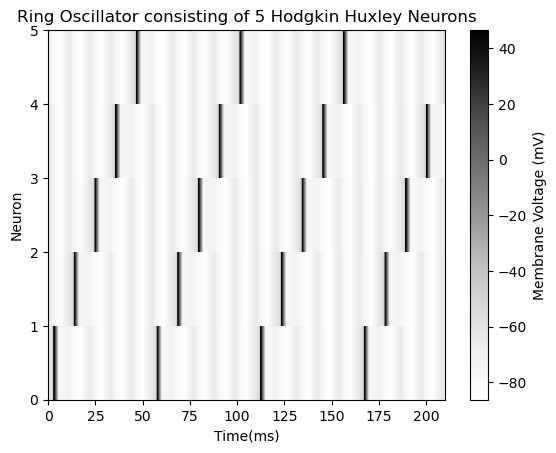

In [4]:
plot_start=1000
data = np.array(outputs)[plot_start:,:,0]

data= np.flip(data,-1)
# Use imshow to create a raster plot, transposing so neurons appear on the y-axis.
plt.imshow(data.T, aspect='auto', interpolation='none', cmap='Greys',extent=[0, data.shape[0] * dt, 0, data.shape[1]])
plt.xlabel('Time(ms)')
plt.ylabel('Neuron')
plt.title('Ring Oscillator consisting of 5 Hodgkin Huxley Neurons')
plt.colorbar(label='Membrane Voltage (mV)')

plt.savefig('HH_ring_raster.png')


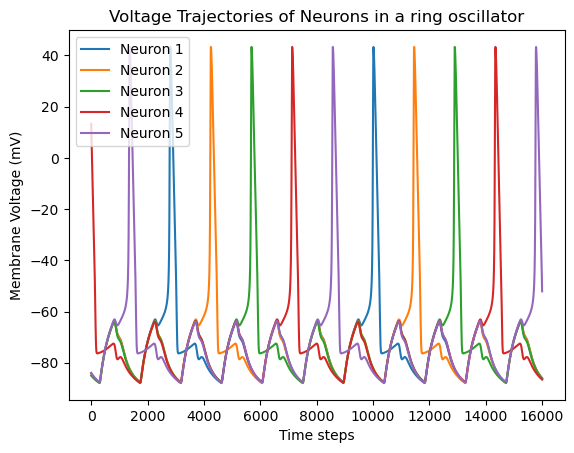

In [127]:
plt.plot(np.array(outputs)[6000:,:,0])
plt.xlabel('Time steps')
plt.ylabel('Membrane Voltage (mV)')
plt.title('Voltage Trajectories of Neurons in a ring oscillator')
plt.legend([f'Neuron {i+1}' for i in range(5)], loc='best')


plt.savefig('HH_ring_plot.png')

## Luka

In [6]:
Time=500
Num_sample=50000
dt=Time/Num_sample
Time_line=np.arange(0,Time,dt)

num_neuron=5

x0=np.random.rand(num_neuron,3)
x=np.copy(x0)
outputs=[x0]

x02=np.random.rand(2,3)
x2=np.copy(x02)
outputs2=[x2]

for i in range(Num_sample):

    u=np.zeros(num_neuron)

    dx=WTA.ring_ss_Luka(num_neuron,x,np.random.rand(num_neuron)*0.1+u,0.3,noise=0.1,inhibit_weight=5,current=1)

    x=x+dx*dt


    outputs.append(x)

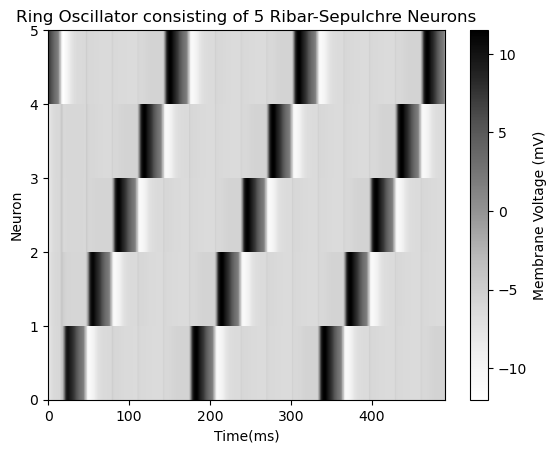

In [8]:
plot_start=1000
data = np.array(outputs)[plot_start:,:,0]

data=np.flip(data,-1)
# Use imshow to create a raster plot, transposing so neurons appear on the y-axis.
plt.imshow(data.T, aspect='auto', interpolation='none', cmap='Greys',extent=[0, data.shape[0] * dt, 0, data.shape[1]])
plt.xlabel('Time(ms)')
plt.ylabel('Neuron')
plt.title('Ring Oscillator consisting of 5 Ribar-Sepulchre Neurons')
plt.colorbar(label='Membrane Voltage (mV)')

plt.savefig('Luka_ring_raster.png')

# Control


## Sim func

In [90]:
import numba

# Assume that WTA.Syn_hh and WTA.ring_ss_hh_vec_numba are already numba-jitted.
# Also note that we now pass mode flags as integers: fre and ent (0 or 1).

@numba.njit(fastmath=True, cache=True)
def simulation_loop_jit(fre, ent,Time):
    Num_sample = int(Time * 100)
    dt = Time / Num_sample
    Time_line = np.empty(Num_sample, dtype=np.float64)
    for i in range(Num_sample):
        Time_line[i] = i * dt

    B = 2
    num_neuron = 5

    # Preallocate batch arrays for state and external input.
    X_batch = np.empty((B, num_neuron, 6), dtype=np.float64)
    U_batch = np.empty((B, num_neuron, 1), dtype=np.float64)

    # Set up initial states for both simulations.
    x0 = np.zeros((num_neuron, 6), dtype=np.float64)
    x0[0, 0] = x0[1, 0] = x0[2, 0] = x0[3, 0] = -75.0
    x = x0.copy()

    x02 = np.zeros((num_neuron, 6), dtype=np.float64)
    x02[0, 0] = x02[1, 0] = x02[2, 0] = x02[3, 0] = -75.0
    x2 = x02.copy()

    # Preallocate output arrays.
    outputs = np.empty((Num_sample + 1, num_neuron, 6), dtype=np.float64)
    outputs2 = np.empty((Num_sample + 1, num_neuron, 6), dtype=np.float64)
    d_current_path = np.empty(Num_sample + 1, dtype=np.float64)
    e_event_path = np.empty(Num_sample + 1, dtype=np.float64)

    # Save initial states.
    for j in range(num_neuron):
        for k in range(6):
            outputs[0, j, k] = x[j, k]
            outputs2[0, j, k] = x2[j, k]
    d_current_path[0] = 0.0
    e_event_path[0] = 0.0

    d_current = 0.0
    e_event = 0.0

    event_counter = True
    event_counter1 = True
    inhibit_w = 10.0

    # Preallocate constant parameter vectors.
    syn_strength_vec = np.full(B, 0.1, dtype=np.float64)
    noise_vec = np.full(B, 0.1, dtype=np.float64)
    inhibit_weight_vec = np.full(B, inhibit_w, dtype=np.float64)

    # Preallocate temporary arrays for external inputs.
    u1 = np.empty((num_neuron, 1), dtype=np.float64)
    u2 = np.empty((num_neuron, 1), dtype=np.float64)
    u_base = np.zeros(num_neuron, dtype=np.float64)

    # Main simulation loop.
    for i in range(Num_sample):
        # --- Determine events for simulation 1 ---
        event = 0
        if event_counter and (x[0, 0] > -40.0):
            event = 1
            event_counter = False
        elif x[0, 0] < -45.0:
            event_counter = True

        # --- Determine events for simulation 2 ---
        event1 = 0
        if event_counter1 and (x2[0, 0] > -40.0):
            event1 = 1
            event_counter1 = False
        elif x2[0, 0] < -45.0:
            event_counter1 = True

        # --- Update e_event and d_current ---
        # e_event = max(min(e_event + ((event - event1) - e_event * dt) / 20000, 1/20000), -1/20000)
        # We implement this logic explicitly.
        temp = e_event + (((event - event1) - e_event * dt) / 20000.0)
        if temp > 1.0/20000.0:
            e_event = 1.0/20000.0
        elif temp < -1.0/20000.0:
            e_event = -1.0/20000.0
        else:
            e_event = temp

        if d_current + e_event * dt * 150.0 < 1.3:
            d_current = (d_current + e_event * dt * 150.0) * fre
        else:
            d_current = 1.3 * fre

        # --- Update batch state arrays ---
        for j in range(num_neuron):
            for k in range(6):
                X_batch[0, j, k] = x[j, k]
                X_batch[1, j, k] = x2[j, k]

        # --- Build external input arrays ---
        for j in range(num_neuron):
            u1[j, 0] = np.random.random() * 0.1

        # u_base: base input for simulation 2.
        for j in range(num_neuron):
            u_base[j] = 0.0
        # Call the Syn_hh function for simulation 1 (make sure it is njitted too).
        u_base[0] = WTA.syn_hh_numba(x[0, 0], 3.0, -45.0) * ent

        for j in range(num_neuron):
            u2[j, 0] = np.random.random() * 0.1 + u_base[j]

        for j in range(num_neuron):
            U_batch[0, j, 0] = u1[j, 0]
            U_batch[1, j, 0] = u2[j, 0]

        # --- Set current vector for each simulation ---
        current_vec = np.empty(2, dtype=np.float64)
        current_vec[0] = -0.2
        current_vec[1] = -1.2 + d_current

        # --- Call the jitted vectorized function ---
        dX_batch = WTA.ring_ss_hh_vec_numba(X_batch, U_batch,
                                            syn_strength_vec,
                                            noise_vec,
                                            inhibit_weight_vec,
                                            current_vec)
        # --- Update state arrays ---
        for j in range(num_neuron):
            for k in range(6):
                x[j, k] = x[j, k] + dX_batch[0, j, k] * dt
                x2[j, k] = x2[j, k] + dX_batch[1, j, k] * dt

        # --- Save outputs ---
        for j in range(num_neuron):
            for k in range(6):
                outputs[i+1, j, k] = x[j, k]
                outputs2[i+1, j, k] = x2[j, k]
        d_current_path[i+1] = d_current
        e_event_path[i+1] = e_event

    return outputs, outputs2, d_current_path, e_event_path, Time_line

dt=1/100

## Two rings (reference and controlled)

### Entrainment

In [95]:
outputs_entrainment,outputs2_entrainment,d_current_path_outputs2_entrainment,e_event_path_outputs2_entrainment,Time_line_ent=simulation_loop_jit(False,True,2000)


(2, 50000)


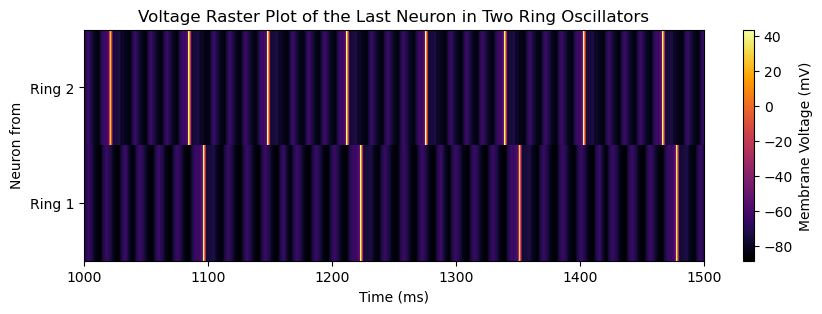

In [96]:
plot_start=100000
plot_end=150000
data1 = outputs_entrainment[plot_start:plot_end,4:5,0] 
data2 = outputs2_entrainment[plot_start:plot_end:,4:5,0] 
data= np.concatenate((data1.T, data2.T), axis=0)

print(data.shape)  # Expected output: (10, number_of_time_steps)

# Define the time step duration (dt)
 # for example, 0.1 ms per time step

# Define the time step duration (dt) # example: each time step represents 0.1 ms

# Create the raster plot
plt.figure(figsize=(10, 3))
plt.imshow(data, aspect='auto', interpolation='none', cmap='inferno', 
           extent=[plot_start* dt, plot_end * dt, 0, data.shape[0]])
plt.xlabel('Time (ms)')
plt.ylabel('Neuron from')
plt.title('Voltage Raster Plot of the Last Neuron in Two Ring Oscillators')
plt.colorbar(label='Membrane Voltage (mV)')

# Create custom y-axis tick labels.
# For example, if you want to label each of the 10 rows with a specific neuron name:
num_neurons = data.shape[0]
# Calculate tick positions at the center of each row
tick_positions = np.arange(0.5, num_neurons, 1)
# Define the neuron names you want to show (make sure the list length equals num_neurons)
neuron_names = [f'Ring {i+1}' for i in range(num_neurons)]
plt.yticks(tick_positions, neuron_names)

# plt.savefig('entrain_voltage_raster_neuron(5)_both_ring.png')
plt.show()

(2, 50000)


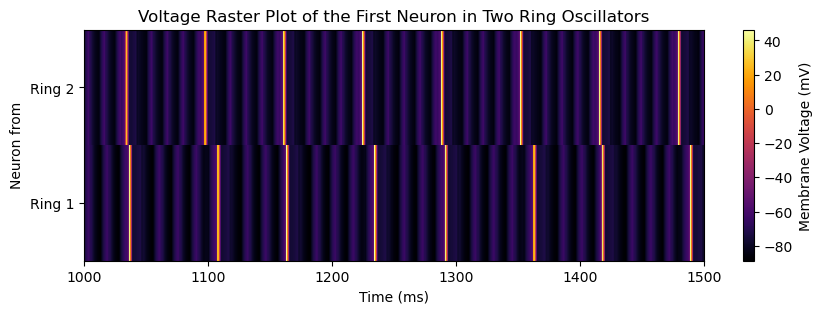

In [42]:
plot_start=100000
plot_end=150000
data1 = outputs_entrainment[plot_start:plot_end,0:1,0] 
data2 = outputs2_entrainment[plot_start:plot_end:,0:1,0] 
data= np.concatenate((data1.T, data2.T), axis=0)

print(data.shape)  # Expected output: (10, number_of_time_steps)

# Define the time step duration (dt)
 # for example, 0.1 ms per time step

# Define the time step duration (dt) # example: each time step represents 0.1 ms

# Create the raster plot
plt.figure(figsize=(10, 3))
plt.imshow(data, aspect='auto', interpolation='none', cmap='inferno', 
           extent=[plot_start* dt, plot_end * dt, 0, data.shape[0]])
plt.xlabel('Time (ms)')
plt.ylabel('Neuron from')
plt.title('Voltage Raster Plot of the First Neuron in Two Ring Oscillators')
plt.colorbar(label='Membrane Voltage (mV)')

# Create custom y-axis tick labels.
# For example, if you want to label each of the 10 rows with a specific neuron name:
num_neurons = data.shape[0]
# Calculate tick positions at the center of each row
tick_positions = np.arange(0.5, num_neurons, 1)
# Define the neuron names you want to show (make sure the list length equals num_neurons)
neuron_names = [f'Ring {i+1}' for i in range(num_neurons)]
plt.yticks(tick_positions, neuron_names)

plt.savefig('entrain_voltage_raster_neuron(0)_both_ring.png')
plt.show()

Data_last shape: (2, 50000)
Data_first shape: (2, 50000)


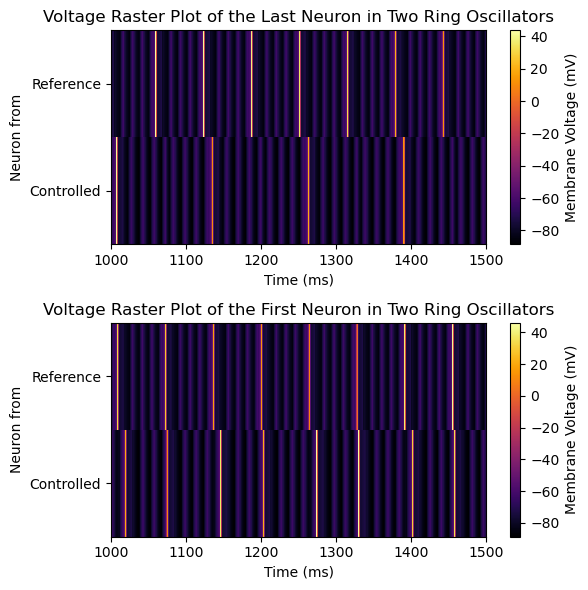

In [89]:
# Example parameters
plot_start = 100000
plot_end = 150000

# --- First raster plot: Last neuron in two ring oscillators ---
data1_last = outputs_entrainment[plot_start:plot_end, 4:5, 0]
data2_last = outputs2_entrainment[plot_start:plot_end, 4:5, 0]
data_last = np.concatenate((data1_last.T, data2_last.T), axis=0)
print("Data_last shape:", data_last.shape)  # Expected output: (10, number_of_time_steps)

# --- Second raster plot: First neuron in two ring oscillators ---
data1_first = outputs_entrainment[plot_start:plot_end, 0:1, 0]
data2_first = outputs2_entrainment[plot_start:plot_end, 0:1, 0]
data_first = np.concatenate((data1_first.T, data2_first.T), axis=0)
print("Data_first shape:", data_first.shape)  # Expected output: (10, number_of_time_steps)

# Create subplots: 2 rows, 1 column
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6))

# --- Plot 1: Raster plot for the last neuron ---
im1 = ax1.imshow(data_last, aspect='auto', interpolation='none', cmap='inferno',
                 extent=[plot_start * dt, plot_end * dt, 0, data_last.shape[0]])
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Neuron from')
ax1.set_title('Voltage Raster Plot of the Last Neuron in Two Ring Oscillators')
cbar1 = fig.colorbar(im1, ax=ax1, label='Membrane Voltage (mV)')

# Set custom y-ticks for ax1
num_neurons = data_last.shape[0]
tick_positions = np.arange(0.5, num_neurons, 1)
neuron_names = ['Controlled','Reference']
ax1.set_yticks(tick_positions)
ax1.set_yticklabels(neuron_names)

# --- Plot 2: Raster plot for the first neuron ---
im2 = ax2.imshow(data_first, aspect='auto', interpolation='none', cmap='inferno',
                 extent=[plot_start * dt, plot_end * dt, 0, data_first.shape[0]])
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Neuron from')
ax2.set_title('Voltage Raster Plot of the First Neuron in Two Ring Oscillators')
cbar2 = fig.colorbar(im2, ax=ax2, label='Membrane Voltage (mV)')

# Set custom y-ticks for ax2
num_neurons = data_first.shape[0]
tick_positions = np.arange(0.5, num_neurons, 1)
neuron_names = ['Controlled','Reference']
ax2.set_yticks(tick_positions)
ax2.set_yticklabels(neuron_names)

plt.tight_layout()
plt.savefig('entrain_combined_raster_plots.png')
plt.show()

### Frequency control

In [38]:
outputs_fre,outputs2_fre,d_current_path_fre,e_event_path_fre,Time_line_fre=simulation_loop_combined_jit(0,True,False,5000)

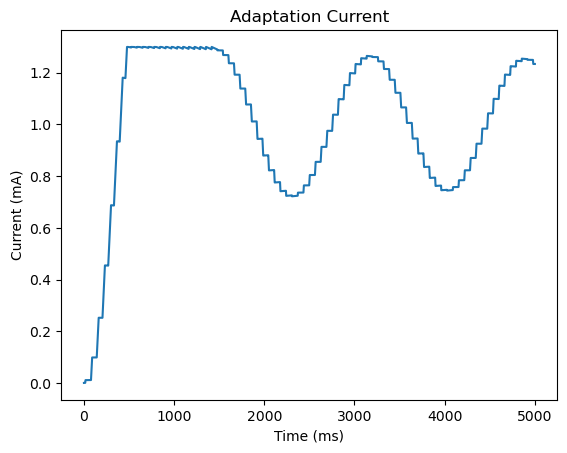

In [39]:
plt.plot(Time_line_fre,d_current_path_fre[1:])
plt.xlabel('Time (ms)')
plt.ylabel('Current (mA)')
plt.title('Adaptation Current')
plt.savefig('fre_adaptation_current.png')

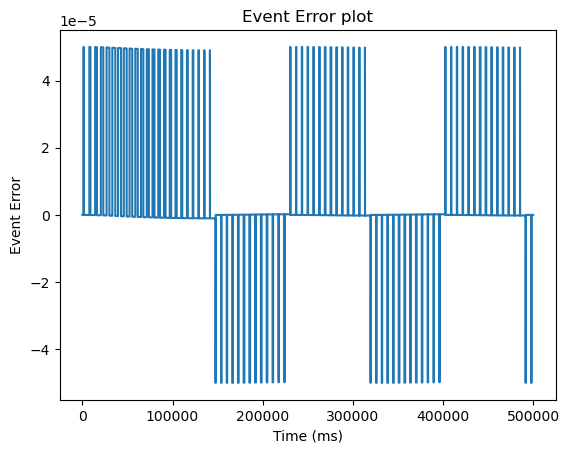

In [46]:
plt.plot(e_event_path_fre)
plt.xlabel('Time (ms)')
plt.ylabel('Event Error')
plt.title('Event Error plot')
plt.savefig('fre_Event_Error.png')

(2, 50000)


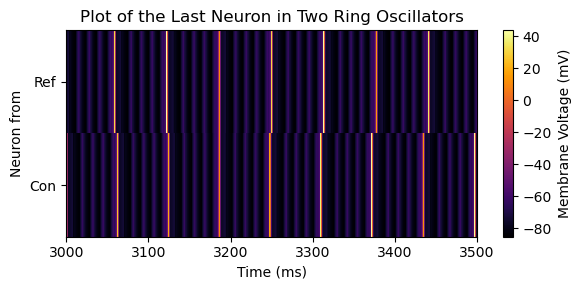

In [40]:
plot_start=300000
plot_end=350000
data1 = outputs_fre[plot_start:plot_end,4:5,0] 
data2 = outputs2_fre[plot_start:plot_end:,4:5,0] 
data= np.concatenate((data1.T, data2.T), axis=0)

print(data.shape)  # Expected output: (10, number_of_time_steps)

# Define the time step duration (dt)
 # for example, 0.1 ms per time step

# Define the time step duration (dt) # example: each time step represents 0.1 ms

# Create the raster plot
plt.figure(figsize=(6, 3))
plt.imshow(data, aspect='auto', interpolation='none', cmap='inferno', 
           extent=[plot_start* dt, plot_end * dt, 0, data.shape[0]])
plt.xlabel('Time (ms)')
plt.ylabel('Neuron from')
plt.title('Plot of the Last Neuron in Two Ring Oscillators')
plt.colorbar(label='Membrane Voltage (mV)')

# Create custom y-axis tick labels.
# For example, if you want to label each of the 10 rows with a specific neuron name:
num_neurons = data.shape[0]
# Calculate tick positions at the center of each row
tick_positions = np.arange(0.5, num_neurons, 1)
# Define the neuron names you want to show (make sure the list length equals num_neurons)
neuron_names = ['Con','Ref']
plt.yticks(tick_positions, neuron_names)
plt.tight_layout()
plt.savefig('fre_voltage_raster_neuron(5)_both_ring.png')
plt.show()

### Frequency and phase control

In [41]:
outputs_fre_ent,outputs2_fre_ent,d_current_path_fre_ent,e_event_path_fre_ent,Time_line_fre_ent=simulation_loop_combined_jit(0,True,True,Time=5000)

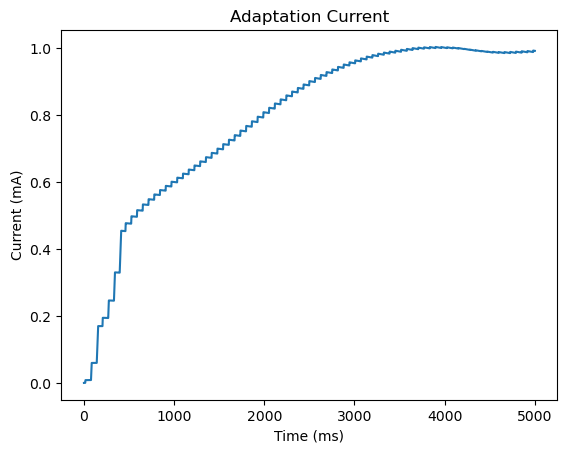

In [42]:
plt.plot(Time_line_fre_ent,d_current_path_fre_ent[1:])
plt.xlabel('Time (ms)')
plt.ylabel('Current (mA)')
plt.title('Adaptation Current')
plt.savefig('fre_ent_adaptation_current.png')

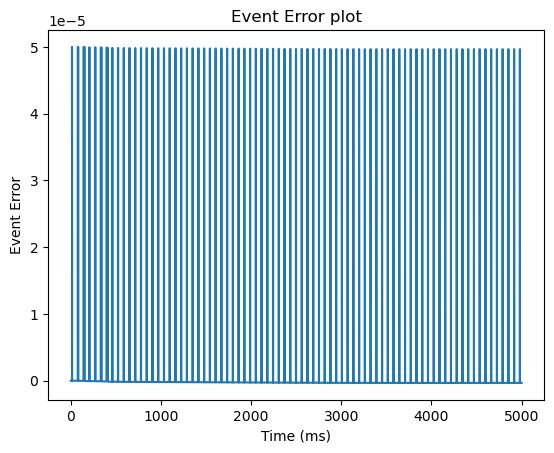

In [43]:
plt.plot(Time_line_fre_ent,e_event_path_fre_ent[1:])
plt.xlabel('Time (ms)')
plt.ylabel('Event Error')
plt.title('Event Error plot')
plt.savefig('fre_ent_Event_Error.png')

(2, 50000)


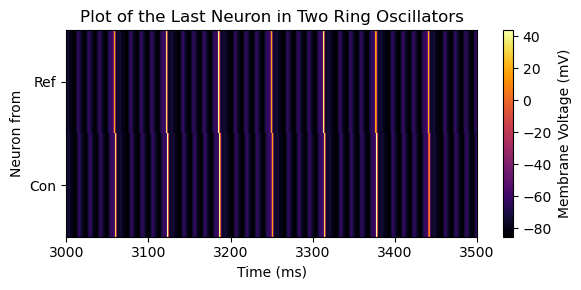

In [44]:
plot_start=300000
plot_end=350000
data1 = outputs_fre_ent[plot_start:plot_end,4:5,0] 
data2 = outputs2_fre_ent[plot_start:plot_end:,4:5,0] 
data= np.concatenate((data1.T, data2.T), axis=0)

print(data.shape)  # Expected output: (10, number_of_time_steps)

# Define the time step duration (dt)
 # for example, 0.1 ms per time step

# Define the time step duration (dt) # example: each time step represents 0.1 ms

# Create the raster plot
plt.figure(figsize=(6, 3))
plt.imshow(data, aspect='auto', interpolation='none', cmap='inferno', 
           extent=[plot_start* dt, plot_end * dt, 0, data.shape[0]])
plt.xlabel('Time (ms)')
plt.ylabel('Neuron from')
plt.title('Plot of the Last Neuron in Two Ring Oscillators')
plt.colorbar(label='Membrane Voltage (mV)')

# Create custom y-axis tick labels.
# For example, if you want to label each of the 10 rows with a specific neuron name:
num_neurons = data.shape[0]
# Calculate tick positions at the center of each row
tick_positions = np.arange(0.5, num_neurons, 1)
# Define the neuron names you want to show (make sure the list length equals num_neurons)
neuron_names = ['Con','Ref']
plt.yticks(tick_positions, neuron_names)
plt.tight_layout()
plt.savefig('voltage_raster_neuron(5)_both_ring.png')
plt.show()

## Sine and ring (reference and controlled)

In [ ]:
Time=5000
Num_sample=500000
dt=Time/Num_sample
Time_line_sine=np.arange(0,Time,dt)

In [ ]:
num_neuron=5

x0=np.random.rand(num_neuron,6)*0
x0[0,0]=-75
x0[2,0]=-75
x0[3,0]=-75
x0[4,0]=-75
x=np.copy(x0)
outputs=[x0]

x02=np.random.rand(num_neuron,6)*0
x02[0,0]=-75
x02[1,0]=-75
x02[2,0]=-75
x02[3,0]=-75
x2=np.copy(x02)
outputs2=[x02]

inhibit_w=10

e_event=0
e_event_path=[]
d_current=0
d_current_path=[]

event_counter=True
event_counter1=True

for i in range(Num_sample):

    y=np.sin(i*dt/10)

    event=0
    event1=0

    if event_counter and (x[0,0]>-40):
        event=1
        event_counter=False
    elif (x[0,0]<-45):
        event_counter=True

    if event_counter1 and (y>0.95):
        event1=1
        event_counter1=False
    elif (y<0.9):
        event_counter1=True


    e_event = max(min(e_event+((event1-event) - e_event*dt)/20000,1/20000),-1/20000)

    d_current= max(min(d_current+e_event*dt*150,1.3),-0.5)

    # --- Build the external input arrays for each simulation ---
    # Here we generate a noise component and add a zero baseline.
    # The u arrays must have shape (num_neuron, 1) per simulation.

    u=np.zeros(num_neuron)
    u[0]=(WTA.Syn_hh((y>0.95)*(40+80)-80,3,-45))

    # --- Pack the state and input arrays into a batch ---
    # X_batch will have shape (2, num_neuron, 6)
    # U_batch will have shape (2, num_neuron, 1)
    X_batch = x[np.newaxis, ...]    # shape becomes (1, num_neuron, 6)
    U_batch = u[np.newaxis, ...,np.newaxis]
    
    # --- Set vectorized parameters ---
    # For the "current" parameter, simulation 1 gets 0.0, simulation 2 gets -1.0 + d_current.
    B = 1
    syn_strength_vec = np.array([0.1])
    noise_vec = np.array([0.1])
    inhibit_weight_vec = np.array([inhibit_w])  # inhibit_w is your scalar value
    current_vec = np.array([-1.0 + d_current])

    
    # Other parameters (syn_strength, noise, inhibit_weight) can be provided as scalars.
    # They will be broadcast to all batch elements.
    
    # --- Call the vectorized function ---
    dX_batch = WTA.ring_ss_hh_vec_numba(X_batch, U_batch,
                                  syn_strength=syn_strength_vec,
                                  noise=noise_vec,
                                  inhibit_weight=inhibit_weight_vec,
                                  current=current_vec)
    
    # --- Unpack the derivatives for each simulation ---
    dx  = dX_batch[0, :, :]  # shape (num_neuron, 6) for simulation 1
    

    # --- Update the state arrays ---
    x  = x  + dx  * dt
    
    # --- Save the outputs ---
    outputs.append(x.copy())
    d_current_path.append(d_current)
    e_event_path.append(e_event)




outputs_sine=np.array(outputs)
d_current_path_sine=np.array(d_current_path)
e_event_path_sine=np.array(e_event_path)

ZeroDivisionError: division by zero

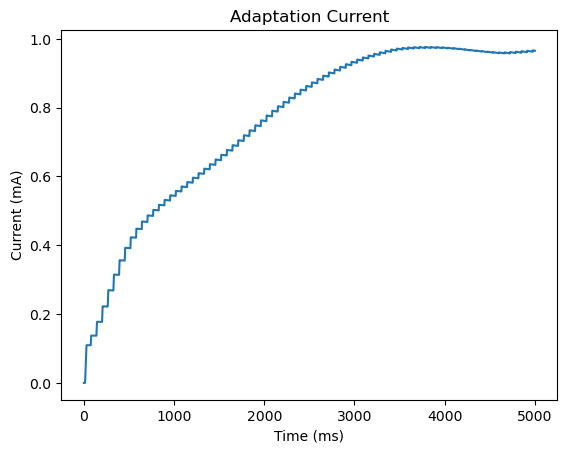

In [ ]:
plt.plot(Time_line_sine,d_current_path_sine)
plt.xlabel('Time (ms)')
plt.ylabel('Current (mA)')
plt.title('Adaptation Current')
plt.savefig('sin_adaptation_current.png')

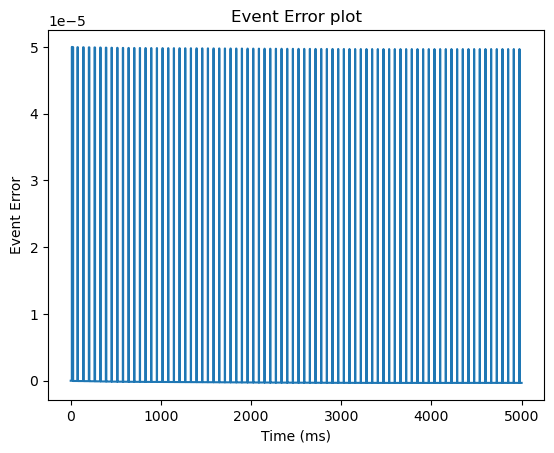

In [ ]:
plt.plot(Time_line_sine,e_event_path_sine)
plt.xlabel('Time (ms)')
plt.ylabel('Event Error')
plt.title('Event Error plot')
plt.savefig('sin_Event_Error.png')

(3, 50000)


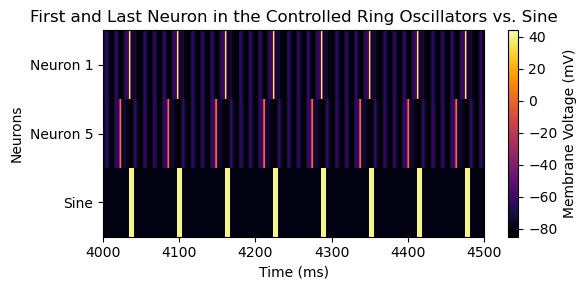

In [ ]:
plot_start=400000
plot_end=450000
data1 = np.array(outputs_sine)[plot_start:plot_end,::4,0] 
data2 = ((np.sin(Time_line_sine/10)>0.95)*(40+80)-80)[plot_start:plot_end,np.newaxis] 
data= np.concatenate((data1.T, data2.T), axis=0)

print(data.shape)  # Expected output: (10, number_of_time_steps)

# Define the time step duration (dt)
 # for example, 0.1 ms per time step

# Define the time step duration (dt) # example: each time step represents 0.1 ms

# Create the raster plot
plt.figure(figsize=(6, 3))
plt.imshow(data, aspect='auto', interpolation='none', cmap='inferno', 
           extent=[plot_start* dt, plot_end * dt ,0, data.shape[0]])
plt.xlabel('Time (ms)')
plt.ylabel('Neurons')
plt.title('First and Last Neuron in the Controlled Ring Oscillators vs. Sine')
plt.colorbar(label='Membrane Voltage (mV)')

# Create custom y-axis tick labels.
# For example, if you want to label each of the 10 rows with a specific neuron name:
num_neurons = data.shape[0]
# Calculate tick positions at the center of each row
tick_positions = np.arange(0.5, num_neurons, 1)
# Define the neuron names you want to show (make sure the list length equals num_neurons)
neuron_names = ['Sine','Neuron 5','Neuron 1']
plt.yticks(tick_positions, neuron_names)
plt.tight_layout()
plt.savefig('sin_voltage_raster_neuron(0).png')
plt.show()

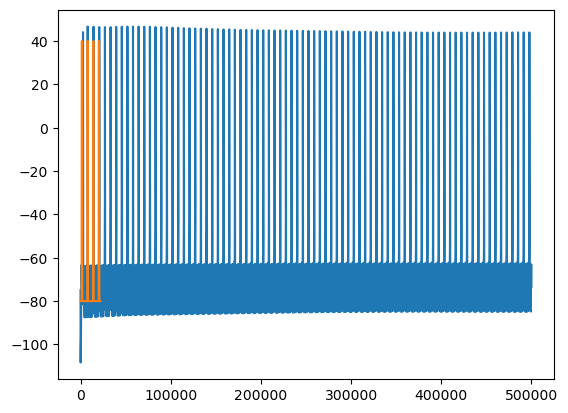

In [ ]:
plt.plot(np.array(outputs)[:,0,0])
plt.plot((np.sin(Time_line/10)>0.95)*(40+80)-80)

## Heterogenius ring

# Total plots

In [ ]:
import numpy as np
import numba

# For illustration, we assume that these helper functions are already njitted:
# @numba.njit
# def syn_hh_numba(V, a, b):
#     return ...   # your implementation
#
# @numba.njit
# def ring_ss_hh_vec_numba(X_batch, U_batch, syn_strength_vec,
#                           noise_vec, inhibit_weight_vec, current_vec):
#     return ...   # your implementation

@numba.njit(fastmath=True, cache=True)
def simulation_loop_options_jit(options, Time, dt=0.01):
    """
    Run the simulation with dynamic option changes.
    
    Parameters:
      options: a 2D array of shape (n, 4) where each row is
               (t_change, sin_enable, fre_con, ent_con).
               It is assumed that options are sorted by t_change.
      Time: total simulation time.
    
    Returns:
      outputs, outputs2: arrays of states over time,
      d_current_path, e_event_path: arrays of the dynamic variables,
      Time_line: array of time stamps.
    """
    # Compute number of time steps and dt.
    Num_sample = int(Time / dt)
    Time_line = np.empty(Num_sample, dtype=np.float64)
    for i in range(Num_sample):
        Time_line[i] = i * dt

    # Number of neurons per simulation.
    num_neuron = 5

    # Initialize state arrays for two simulations.
    x = np.zeros((num_neuron, 6))
    x2 = np.zeros((num_neuron, 6))
    # Set initial conditions (only selected neurons get -75).
    x[0, 0] = -75.0
    x[2, 0] = -75.0
    x[3, 0] = -75.0
    x[4, 0] = -75.0
    x2[0, 0] = -75.0
    x2[1, 0] = -75.0
    x2[2, 0] = -75.0
    x2[3, 0] = -75.0

    # Preallocate outputs.
    outputs = np.empty((Num_sample + 1, num_neuron, 6))
    outputs2 = np.empty((Num_sample + 1, num_neuron, 6))
    for j in range(num_neuron):
        for k in range(6):
            outputs[0, j, k] = x[j, k]
            outputs2[0, j, k] = x2[j, k]

    # Preallocate paths for d_current and e_event.
    d_current_path = np.empty(Num_sample + 1)
    e_event_path = np.empty(Num_sample + 1)
    d_current_path[0] = 0.0
    e_event_path[0] = 0.0

    # Initialize dynamic variables.
    e_event = 0.0
    d_current = 0.0
    event_counter = True
    event_counter1 = True
    inhibit_w = 10.0
    last_sin_enable=0

    # Preallocate constant parameter vectors for the batch HH call.
    B = 2
    syn_strength_vec = np.empty(B)
    noise_vec = np.empty(B)
    inhibit_weight_vec = np.empty(B)
    for b in range(B):
        syn_strength_vec[b] = 0.1
        noise_vec[b] = 0.1
        inhibit_weight_vec[b] = inhibit_w

    # Preallocate batch arrays for states and inputs.
    X_batch = np.empty((B, num_neuron, 6))
    U_batch = np.empty((B, num_neuron, 1))
    # Preallocate temporary arrays for external inputs.
    u1 = np.empty((num_neuron, 1))
    u2 = np.empty((num_neuron, 1))
    u = np.empty(num_neuron)

    # --- Option scheduling ---
    # options is assumed to have shape (n, 4): 
    # col0: t_change, col1: sin_enable, col2: fre_con, col3: ent_con.
    n_options = options.shape[0]
    opt_idx = 0
    # Set initial option values (defaults).
    current_sin_enable = 0.0  # off by default
    current_fre_con = 0.0     # default value
    current_ent_con = 1.0     # default value
    if n_options > 0 and options[0, 0] <= 0.0:
        current_sin_enable = options[0, 1]
        current_fre_con    = options[0, 2]
        current_ent_con    = options[0, 3]
        opt_idx = 1

    # Main simulation loop.
    for i in range(Num_sample):
        t_now = i * dt
        # Check if it's time to update options.
        if opt_idx < n_options:
            if t_now >= options[opt_idx, 0]:
                current_sin_enable = options[opt_idx, 1]
                current_fre_con    = options[opt_idx, 2]
                current_ent_con    = options[opt_idx, 3]
                opt_idx += 1

        y = np.sin(i * dt / 12.0)

        # Determine events for simulation 1 (using x2).
        event1 = 0
        if event_counter1 and (x2[0, 0] > -20.0):
            event1 = 1
            event_counter1 = False
        elif x2[0, 0] < -25.0:
            event_counter1 = True

        # Determine events for simulation 2 (using x), using current_sin_enable.
        event = 0
        if current_sin_enable == 0.0:
            if event_counter and (x[0, 0] > -20.0):
                event = 1
                event_counter = False
            elif x[0, 0] < -25.0:
                event_counter = True
        else:
            if event_counter and (y > 0.95):
                event = 1
                event_counter = False
            elif y < 0.9:
                event_counter = True

        if last_sin_enable!=current_sin_enable:
            e_event=0
            event=0
            event1=0
            event_counter=True
            event_counter1=True
            last_sin_enable=current_sin_enable

        # Update e_event (with saturation).
        
        temp = e_event + (((event - event1) - e_event * dt) / 7000.0)
        if temp > 1.0 / 7000.0:
            e_event = 1.0 / 7000.0
        elif temp < -1.0 / 7000.0:
            e_event = -1.0 / 7000.0
        else:
            e_event = temp

        if d_current + e_event * dt * 130.0 < 2.3:
            d_current = (d_current + e_event * dt * 130.0) * current_fre_con
        else:
            d_current = 2.3 * current_fre_con

        if d_current < -1.5:
            d_current = -1.5

            


        # --- Build the external input arrays ---
        for j in range(num_neuron):
            u1[j, 0] = np.random.random() * 0.0
        for j in range(num_neuron):
            u[j] = 0.0
        # Use the current option for ent_con when computing synaptic input.
        if current_fre_con == 0.0:

            if current_sin_enable == 0.0:
                temp_syn = WTA.syn_hh_numba(x[0, 0], 3, -45.0)
            else:
                temp_syn = WTA.syn_hh_numba((event_counter==False) * (40.0 + 80.0) - 80.0, 3.0, -45.0)

        else:

            if current_sin_enable == 0.0:
                temp_syn = WTA.syn_hh_numba(x[0, 0], 1, -45.0)
            else:
                temp_syn = WTA.syn_hh_numba((event_counter==False) * (40.0 + 80.0) - 80.0, 1.0, -45.0)


        u[0] = temp_syn * current_ent_con
        for j in range(num_neuron):
            u2[j, 0] = np.random.random() * 0.0 + u[j]

        # Pack states into batch array.
        for j in range(num_neuron):
            for k in range(6):
                X_batch[0, j, k] = x[j, k]
                X_batch[1, j, k] = x2[j, k]
        # Pack inputs into batch array.
        for j in range(num_neuron):
            U_batch[0, j, 0] = u1[j, 0]
            U_batch[1, j, 0] = u2[j, 0]

        current_vec = np.empty(B)
        current_vec[0] = 1
        current_vec[1] = -1 + d_current

        # Call the vectorized HH function.
        dX_batch = WTA.ring_ss_hh_vec_numba(X_batch, U_batch,
                                             syn_strength_vec,
                                             noise_vec,
                                             inhibit_weight_vec,
                                             current_vec)
        # Update state arrays.
        for j in range(num_neuron):
            for k in range(6):
                x[j, k] = x[j, k] + dX_batch[0, j, k] * dt
                x2[j, k] = x2[j, k] + dX_batch[1, j, k] * dt

        # Save outputs.
        for j in range(num_neuron):
            for k in range(6):
                outputs[i + 1, j, k] = x[j, k]
                outputs2[i + 1, j, k] = x2[j, k]
        d_current_path[i + 1] = d_current
        e_event_path[i + 1] = e_event

    return outputs, outputs2, d_current_path, e_event_path, Time_line

dt=1/100

In [537]:
options=[[0,0,0,0],[1000,0,0,1],[1900,0,1,1],[5000,1,1,1]]
options=np.array(options)
outputs_total,outputs2_total,d_current_path_total,e_event_path_total,Time_line_total=simulation_loop_options_jit(options,8000,0.01)

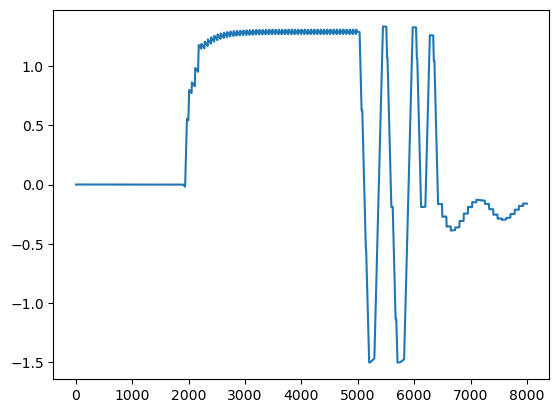

In [538]:
plt.plot(Time_line_total,d_current_path_total[1:])

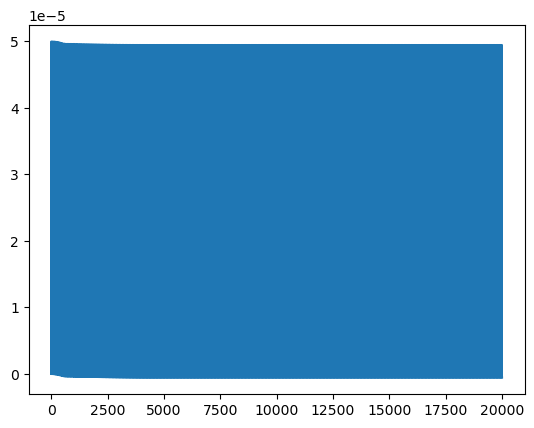

In [244]:
plt.plot(Time_line_total,e_event_path_total[1:])

(800000, 11)


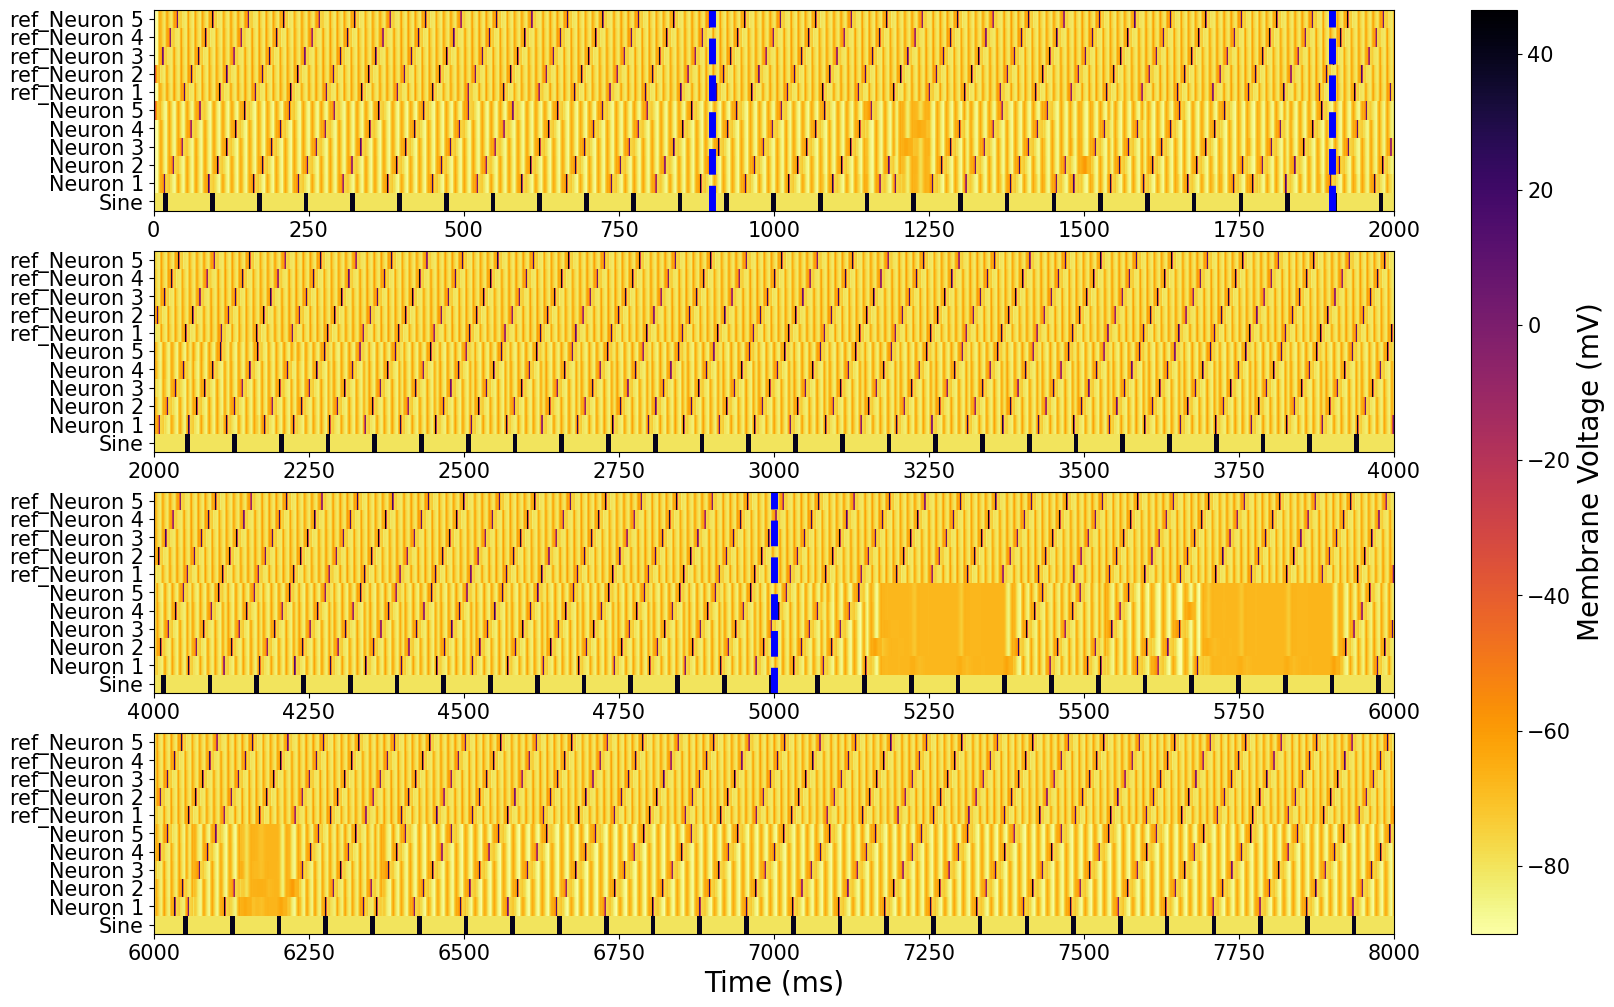

In [539]:
start_time=0
data0 = np.array(outputs_total)[start_time+1:,::-1,0]

data1 = np.array(outputs2_total)[start_time+1:,::-1,0]

data2 = ((np.sin(Time_line_total[start_time::]/12)>0.95)*(40+80)-80)[:,np.newaxis] 

data= np.concatenate((data0.T,data1.T, data2.T,), axis=0).T

print(data.shape)  # Expected output: (10, number_of_time_steps)

vmin_val = -90 
vmax_val = np.max(data)

caption_size=20
tick_size=15
label_size=20

vertical_lines = [900, 1900, 5000]

n_timepoints = data.shape[0]
n_segments = 4  # for instance, split into 4 segments
segment_length = n_timepoints // n_segments

fig, axes = plt.subplots(n_segments, 1, figsize=(20, 12), sharey=True)


for i, ax in enumerate(axes):
    start = i * segment_length
    # Ensure the last segment includes any leftover points
    end = (i+1) * segment_length if i < n_segments - 1 else n_timepoints
    segment = data[start+start_time:end+start_time, :].T
    im = ax.imshow(segment, aspect='auto', interpolation='none', cmap='inferno_r', vmin=vmin_val, vmax=vmax_val,
                   extent=[(start +start_time)* dt, (end +start_time)*dt, 0, data.shape[1]])
    tick_positions = np.arange(0.5, 11, 1)
    # Define the neuron names you want to show (make sure the list length equals num_neurons)
    neuron_names = ['Sine','Neuron 1','Neuron 2','Neuron 3','Neuron 4','Neuron 5','ref_Neuron 1','ref_Neuron 2','ref_Neuron 3','ref_Neuron 4','ref_Neuron 5']
    ax.set_yticks(tick_positions, neuron_names, fontsize=tick_size)
    ax.tick_params(axis='x', labelsize=tick_size)
    # ax.set_title(f'Time: {start*dt:.1f} ms - {end*dt:.1f} ms')

    for line in vertical_lines:
        if (start+start_time)*dt <= line <= (end+start_time)*dt:
            ax.axvline(x=line, color='blue', linestyle='--', linewidth=5)

plt.xlabel('Time (ms)', fontsize=label_size)
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), label='Membrane Voltage (mV)')
cbar.set_label('Membrane Voltage (mV)', fontsize=label_size)  # Change label font size
cbar.ax.tick_params(labelsize=tick_size)

plt.show()

fig.savefig('total_voltage_raster.png')